# Primary Component Analysis (PCA)

## Objective
Demonstrate the underlying mechanisms of reduceing the dimension N of data into k (k << N), using MNIST (28x28 pixel images) and the application of PCA (Scikit Learn).

## Idea
The idea of dimensionality reduction is to decompose the data by projecting it into N primary component (PC) axes, and represent the total information of the data as a linear sum of the variance at each axis. 

The distribution of the data points represents the information that the data brings. The direction where the data varies more carries more information. 

<pre>
<img align="left" src="./images/pca/primary_direction.png" width="300">
</pre>

Identify the vector that varies the most (PC1), and then the second most (PC2), and continue to the least most (PCn). The amount of information at each PC is given by its variance, which can be used to quantify the contribution of each PC.

### Diagonalization
Data is represented as a matrix. By diagonalisation of the matrix, we can get eigenvectors and eignvalues. The eigenvectors are the PCs and the eigenvalues are the variances of the PCs.

### SVD
The diagalisation requires calculating the product of the transpose of the matrix and the matrix itself, for which we may need significant memory space and time, or more time if we do it a sequential manner to avoid memory overflow. SVD provides the way to get he eigenvectors and eignvalues without diagonalisation.

## Pre-requisite

The dataset needs to be centered around the origin. To do it manually by yourself with numpy (Scikit Learn PCA looks after centering the data, hence not required).

```
X_centered = X - X.mean(axis=0)
```

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import scipy as sp
import os

# to make this notebook's output stable across runs
np.random.seed(42)
np.set_printoptions(
    suppress=True #, formatter={'float_kind':'{:0.5f}'.format}
)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
%%html
<!-- To left align the HTML components in Markdown -->
<style>
table {float:left}
</style>

In [23]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [24]:
# Total percentage of the information in the data to preserve after reducing the dimensions
COVERAGE = 0.95

## Loading MNIST data

In [9]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)
NUM_CLASSES=10

In [10]:
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#del mnist

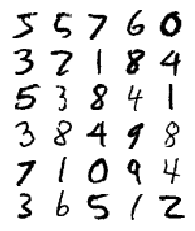

In [38]:
plot_digits(X_train[::2000])
plt.show()

# Mathematics

## Map (Rotate & Extend)
<img align="left" src="./images/pca/basis.rotate_to_map.png" width="400"> 

## Transpose
<img align="left" src="./images/pca/VT.Semantic.png" width="1000"> 

## Diagonalization
It is able to find the onthogonal bases, in the space of which the co-variances of the data becomes 0.

<img align="left" src="./images/pca/basis.diagonalization.png" width="1000">

## Primary Components

In the diagonalised space, the variance along each basis is the contribution to the information that the data posseses. The basis along which the data has the maximum variance is the 1st primary component of the data. The basis that has 2nd maximum variance is the 2nd primary compoent, and so on. 

<img align="left" src="./images/pca/basis.variance_is_contribution.png" width="1000"> 

## Eigenvectors

Those onthogonal bases are the eigenvectors and the eigenvalues are the variances. 

<img align="left" src="./images/pca/basis.variance_to_primary_component.png" width="1000"> 


## Eigenvalues
Hence Primary Comonents can be identified from the eigenvalues. Contribution at each basis to the total information is <span style="color:red"><b>its variance</b></span>, which is represented by eigenvalues.

In [14]:
X_centered = X_train - X_train.mean(axis=0)

covariance_matrix = X_centered.T.dot(X_centered) 
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

### Plot eigenvalue cumulative

Visualize how much percentage of the total information in the data can be represented with how many primary components.

In [15]:
def plot_coverage(cumulatives, xlabel, ylabel):
    dimensions = range(0, len(cumulatives))

    # --------------------------------------------------------------------------------
    # Axes
    # [Axis limits]
    # With plt.axes() you are creating a new axes again. 
    # Use ax.set_xlim(a,b) and ax.set_ylim(a,b)
    # --------------------------------------------------------------------------------
    #plt.axis((0,max(dimensions),0,1.01))
    # --------------------------------------------------------------------------------
    ax = plt.gca()
    ax.set_xlim(0, max(dimensions))
    ax.set_ylim(0, 1.01)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # --------------------------------------------------------------------------------
    # Grid
    # --------------------------------------------------------------------------------
    import math
    import matplotlib.ticker as ticker

    plt.grid(
        color='b',
        linestyle='--',
        linewidth=0.5,
        which='both'     # Both major and minor grids
    )

    # --------------------------------------------------------------------------------
    # Minor grid to highlight the range for the COVERAGE
    # --------------------------------------------------------------------------------
    k = np.argmax(cumulatives >= COVERAGE)
    print("k-th primary compoent for {0} coverage is {1}".format(str(COVERAGE), k))
    
    minors = range(0, math.ceil(k/100)*100, 10)[1:-1]
    ax.xaxis.set_minor_locator(ticker.FixedLocator(minors))
    ax.grid(
        which='minor', # Set the minor grid attributes
        alpha=0.5,     # Transparency
        lw=1, 
        color='r'
    )

    # --------------------------------------------------------------------------------
    # Cut-off COVERAGE line 
    # --------------------------------------------------------------------------------
    plt.plot([0.0, max(dimensions)], [COVERAGE, COVERAGE], "r:", lw=2, label=str(COVERAGE))
    
    # --------------------------------------------------------------------------------
    # Information coverage along Primary Components 
    # --------------------------------------------------------------------------------
    plt.plot(dimensions, cumulatives)

    plt.legend(
        loc='upper right',          # Legend location
        bbox_to_anchor=(0.98, 0.9), # Adjust the legend location
        prop={'size': 15}           # Font size
    )
    plt.show

k-th primary compoent for 0.95 coverage is 153


/home/masa/anaconda3/envs/Jupyter-Notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


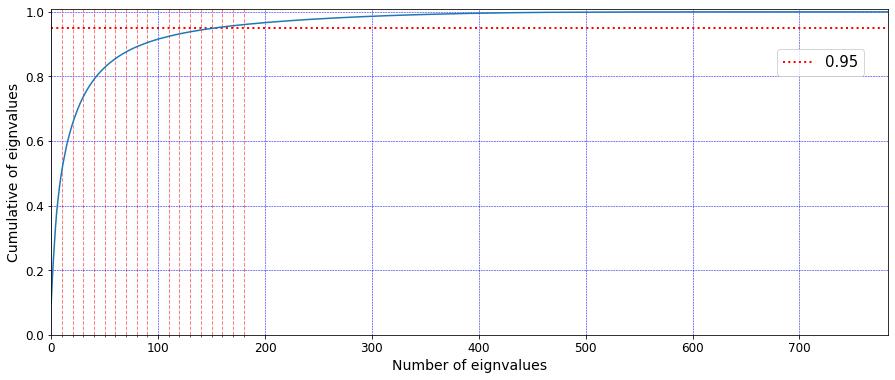

In [16]:
plt.figure(figsize=(15, 6))
plot_coverage(
    (eigenvalues / eigenvalues.sum()).cumsum(), 
    "Number of eignvalues", 
    "Cumulative of eignvalues"
)

154 PCs can preserve the COVERAGE (*100) percentage of the information in the data.

In [18]:
del eigenvalues

<hr/>

# PCA

Demonstrate the Scikit Learn PCA(Primary Component Analysis) which implement the same idea of using eignvectors and eignvalues, to identify the top <b>k</b> primary components and ignore the rest of the components, by which the dimentionality can be reduced from n to k.

<img align="left" src="./images/pca/pca.idea.png" width="400">
<br/>

## Choosing k

Find <b>k</b> which covers 99% (or 95%) of the variance of the data. <br/>. The coverage is specified in the COVERGE variable.

<cite><b> Andrew Ng</b></cite>
<pre>
<img align="left" src="./images/pca/andrew_ng_choosing_k.png" width="750">
</pre>

In [19]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

## Identify k for the coverage

Idenify the number of component (k+1) that cover the COVERAGE % of the information that the data has.

k-th primary compoent for 0.95 coverage is 153
Top 5 primary component contributions: [0.09705 0.07096 0.06169 0.05389 0.04869]
Coverage by the top 5 primary components: [0.09705 0.16801 0.2297  0.28359 0.33228]


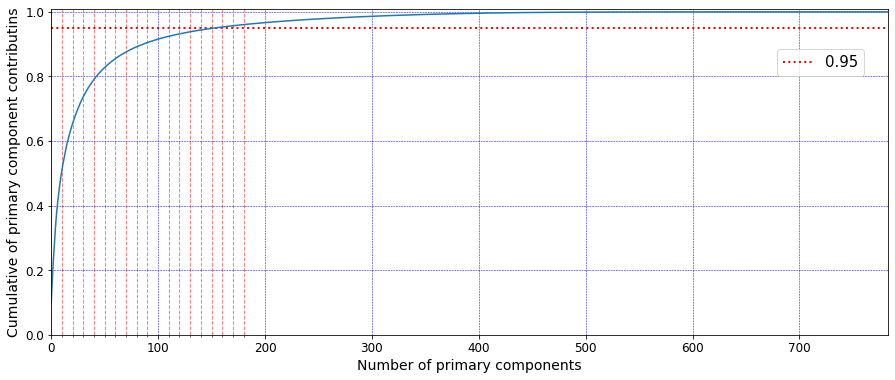

In [20]:
contribution_cumulatives = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(15, 6))
plot_coverage(
    pca.explained_variance_ratio_.cumsum(), 
    "Number of primary components", 
    "Cumulative of primary component contributins"
)

print("Top 5 primary component contributions: {}".
      format(np.round(pca.explained_variance_ratio_[:5], decimals=5))
)
print("Coverage by the top 5 primary components: {}".
      format(np.round(contribution_cumulatives[:5], decimals=5))
)

## Effect of the dimensionality reduction

Compare the original image and the one restored from the dimensionality reduced data.

In [21]:
pca = PCA(
    n_components=np.argmax(pca.explained_variance_ratio_.cumsum() >= COVERAGE) #, 
#    svd_solver="randomized", 
#    random_state=4
)
X_train_reduced = pca.fit_transform(X_train)
X_train_recovered = pca.inverse_transform(X_train_reduced)

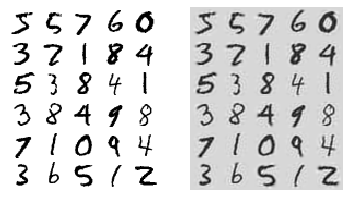

In [25]:
plt.subplot(121)
plot_digits(X_train[::2000])

plt.subplot(122)
plot_digits(X_train_recovered[::2000])
#plt.tight_layout()

In [26]:
#del X_train_reduced, X_train_recovered
#del pca, _pca

In [27]:
%%html
<style>
row {float:left}
</style>

## Visualize how two primary compoents can classify 
| PC | PC | Description         
| :- | :- | :-
|PC1 | PC1 |Classifies digit 0  
|PC1 | PC2 |Classifies digit 1, 2, 7  
|PC2 | PC3 |Classifies digit 3
|PC2 | PC4 |Classifies digit 2, 7
|PC4 | PC4 |Classifies digit 6


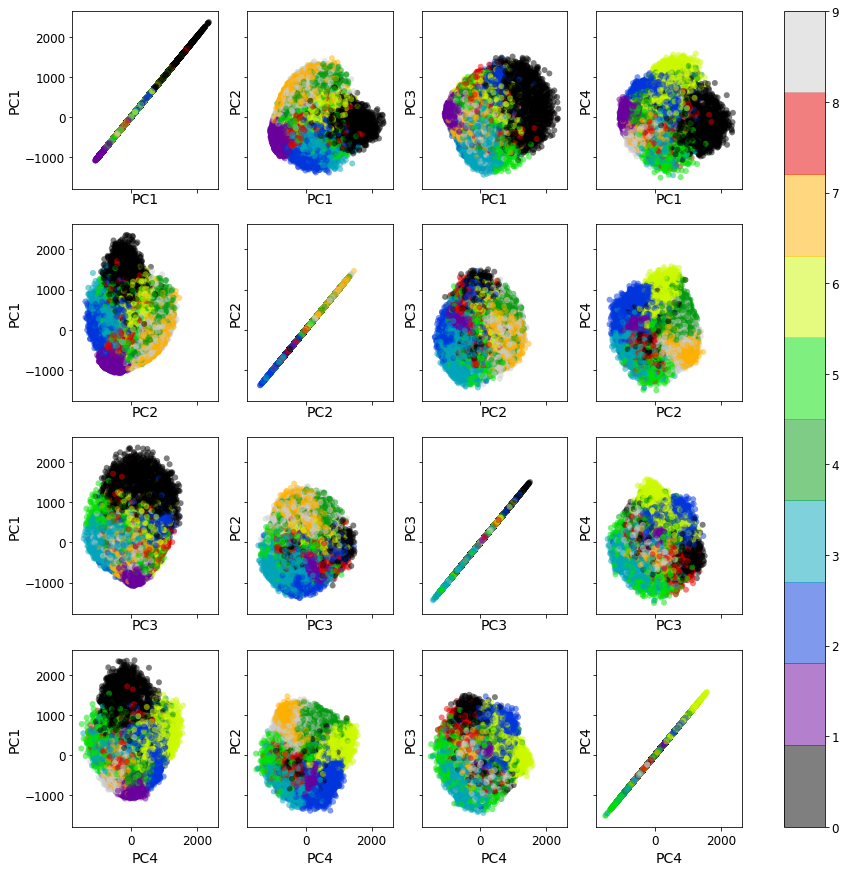

In [28]:
import matplotlib as mpl

%matplotlib inline
nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(15, 15))

def plot_grid(projected, axes, x, y):
    path = axes[x, y].scatter(
        projected[:, x],
        projected[:, y], 
        c=y_train, 
        edgecolor='none', 
        alpha=0.5,
        cmap=plt.cm.get_cmap('nipy_spectral', 10)
    )
    axes[x, y].set_xlabel('PC{}'.format(x+1))
    axes[x, y].set_ylabel('PC{}'.format(y+1))
    return path

for i in range(0, nrows * ncols):
    path = plot_grid(X_train_reduced, axes, i % ncols, i // nrows)

cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat], orientation="vertical")
plt.colorbar(path, cax=cax, **kw)
   
#plt.tight_layout()
plt.show()

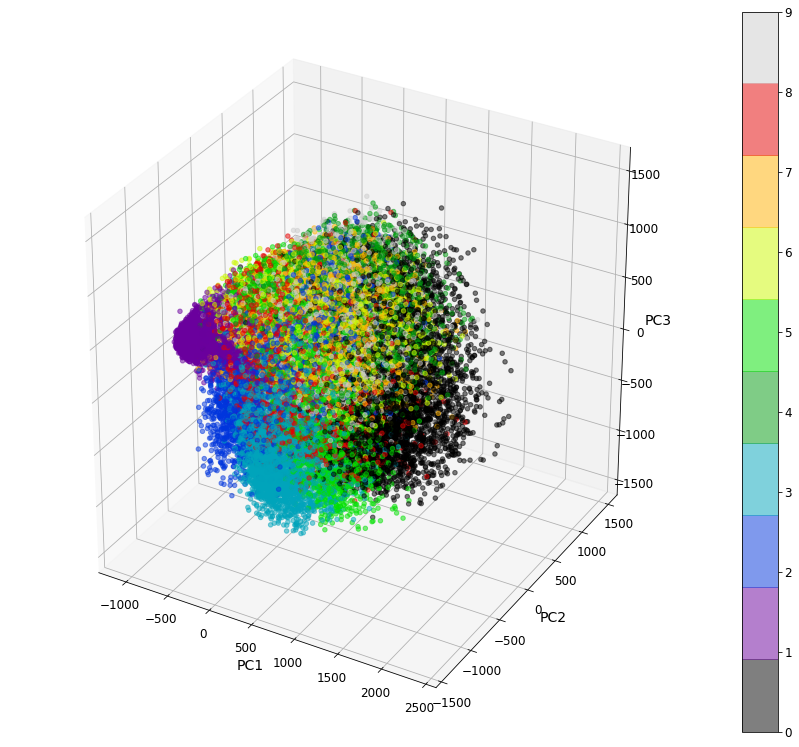

In [29]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib qt
def plot_grid_3D(projected, fig):
    ax = Axes3D(fig)
    path = ax.scatter(
        projected[:, 0], 
        projected[:, 1],
        projected[:, 2],
        c=y_train, 
        alpha=0.5,
        cmap=plt.cm.get_cmap('nipy_spectral', 10)
    )
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    fig.colorbar(path)
    plt.show()
    
fig = plt.figure(figsize=(12, 10))
plot_grid_3D(X_train_reduced, fig)

## KNN on dimension reduced data

Demonstrate the KNN (K Nearest Neighbour) to predict the hand written digits on the dimension reduced data.

In [32]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(
    n_neighbors=NUM_CLASSES, 
    weights='uniform',
    n_jobs=-1           # Use all processors
)

params_knn = knn.get_params()
print("KNN parameters = {}".format(params_knn))

KNN parameters = {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}


In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'weights': ["uniform", "distance"], 
        'n_neighbors': [NUM_CLASSES]
    }
]
grid_search = GridSearchCV(knn, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train_reduced, y_train)
knn = grid_search.best_estimator_

print("GridSearchCV best parameters for KNN is {}".format(grid_search.best_params_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  5.9min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.2min finished


GridSearchCV best parameters for KNN is {'n_neighbors': 10, 'weights': 'distance'}


### Confusion matrix
Confusion matrix of the reduced data prediction result.

In [34]:
from sklearn.metrics import confusion_matrix
X_test_reduced = pca.transform(X_test)
y_test_pred_knn = knn.predict(X_test_reduced)
confusion_matrix(y_test, y_test_pred_knn)

array([[ 973,    1,    1,    0,    0,    1,    3,    1,    0,    0],
       [   0, 1130,    2,    0,    0,    0,    2,    0,    0,    1],
       [  11,    3,  992,    2,    1,    0,    2,   15,    6,    0],
       [   0,    3,    1,  976,    1,   12,    0,    7,    6,    4],
       [   2,    8,    0,    0,  943,    0,    5,    2,    1,   21],
       [   3,    0,    0,    6,    2,  868,    7,    1,    1,    4],
       [   5,    3,    0,    0,    3,    1,  946,    0,    0,    0],
       [   0,   23,    4,    0,    1,    0,    0,  989,    0,   11],
       [   6,    2,    3,   12,    7,    6,    3,    6,  924,    5],
       [   4,    7,    2,    7,    7,    4,    1,    7,    2,  968]])

### Comparing with not reduced data result

Comparing with the prediction result confusion matrix from non-reduced data, the reduced data traning gives similar result.
<pre>
array([[ 972,    1,    1,    0,    0,    2,    3,    1,    0,    0],
       [   0, 1132,    2,    0,    0,    0,    1,    0,    0,    0],
       [  13,   10,  983,    2,    1,    0,    2,   17,    4,    0],
       [   0,    3,    1,  975,    1,   12,    1,    7,    5,    5],
       [   1,   11,    0,    0,  940,    0,    4,    1,    1,   24],
       [   4,    0,    0,    4,    2,  868,    6,    1,    1,    6],
       [   6,    4,    0,    0,    3,    2,  943,    0,    0,    0],
       [   0,   25,    3,    0,    1,    0,    0,  987,    0,   12],
       [   6,    4,    4,   10,    6,    8,    3,    6,  919,    8],
       [   5,    6,    3,    5,    8,    4,    1,   10,    2,  965]])
</pre>

In [35]:
from sklearn.metrics import precision_recall_fscore_support as score
precision_knn, recall_knn, fscore_knn, support_knn = score(y_test, y_test_pred_knn)

import pandas as pd
data_knn = [
#    np.append(["Accracy"], accuracy_knn),
    np.append(["Precision"], precision_knn),
    np.append(["Recall"], recall_knn),
    np.append(["F1"], fscore_knn),
    np.append(["Support"], support_knn)
]
pd.DataFrame(data_knn)

,0,1,2,3,4,5,6,7,8,9,10
0,Precision,0.9691235059760956,0.9576271186440678,0.9870646766169154,0.9730807577268196,0.9772020725388602,0.9730941704035875,0.9762641898864809,0.9620622568093385,0.9829787234042553,0.9546351084812623
1,Recall,0.9928571428571429,0.9955947136563876,0.9612403100775194,0.9663366336633663,0.960285132382892,0.9730941704035875,0.9874739039665971,0.9620622568093385,0.9486652977412731,0.9593657086223984
2,F1,0.9808467741935484,0.9762419006479482,0.9739813451153658,0.9696969696969697,0.9686697483307652,0.9730941704035875,0.9818370524130774,0.9620622568093385,0.9655172413793103,0.9569945625308947
3,Support,980,1135,1032,1010,982,892,958,1028,974,1009


In [36]:
del pca, X_train_reduced, X_test_reduced, y_test_pred_knn

# SVD

Demonstrate SVD mechanism and usage in reducing dimeisions, which is actually used in Scikit Learn PCA.

[We Recommend a Singular Value Decomposition](http://www.ams.org/publicoutreach/feature-column/fcarc-svd)<br>

<img align="left" src="./images/pca/onthgonal_to_onthogonal.png" width="800">
<img align="left" src="./images/pca/SVDInduction.png" width="800">

With those (u, v), any matrix M, including a Covariance Matrix, can be decomposed as below.
<br/>
<img align="left" src="./images/pca/SVD.png" width="1000">

## Relation between SVD and PCA

The eignvectors <b>E</b> of PCA is the same with the singular vector <b>V</b> of SVD. <br/>
<img align="left" src="./images/pca/PCA_SVD_Relation.png" width="500">
<img align="left" src="./images/pca/SVD2PCA.png" width="1000">
<img align="left" src="./images/pca/SVD_PCA.png" width="1000">

### Plot singular value cumulative

Visualize how much percentage of the total information in the data can be represented with how many singular values.

In [37]:
X_centered = X_train - X_train.mean(axis=0)
# --------------------------------------------------------------------------------
# Use scipy to avoid numpy MemoryError: Unable to allocate array with shape
# https://stackoverflow.com/questions/19743525/
# https://github.com/numpy/numpy/issues/4268
# http://fa.bianp.net/blog/2012/singular-value-decomposition-in-scipy/
#
# Use full_matrices=False
# --------------------------------------------------------------------------------
#U, s, Vt = np.linalg.svd(X_mm - X_mm.mean(axis=0))
# --------------------------------------------------------------------------------
U, s, Vt= sp.linalg.svd(X_centered, full_matrices=False)
# --------------------------------------------------------------------------------

In [39]:
n_samples, n_features = X_centered.shape

sigma_cumulatives = ((s ** 2) / (n_samples - 1)).cumsum()
sigma_cumulatives = sigma_cumulatives / sigma_cumulatives[-1]

k-th primary compoent for 0.95 coverage is 153


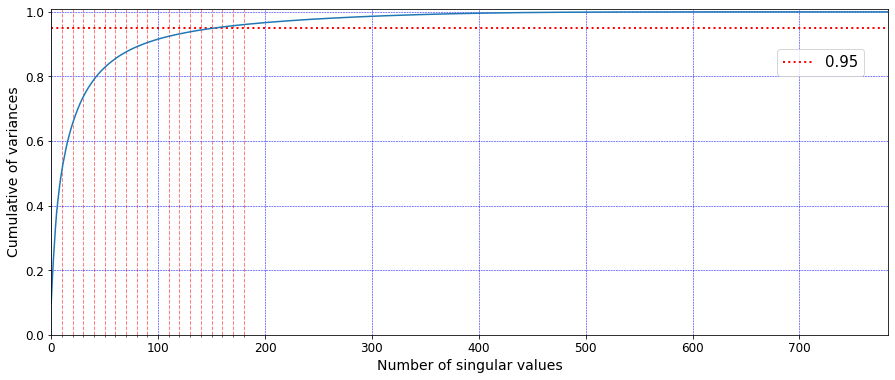

In [40]:
%matplotlib inline
plt.figure(figsize=(15, 6))
plot_coverage(
    sigma_cumulatives, 
    "Number of singular values",
    "Cumulative of variances"
)

# Handling large data

Ways to run PCA on a huge data set which may not fit into the memory.


## Incremental PCA
A large data can be split into mini-batches and Scikit learn IncrementalPCA can take one mini-batch at a time.

In [41]:
_X_train = np.copy(X_train)

In [42]:
from sklearn.decomposition import IncrementalPCA

m, n = _X_train.shape
n_batches = 100

ipca = IncrementalPCA(batch_size=(m // n_batches))
ipca.fit(_X_train)
"""
ipca = IncrementalPCA()
for X_batch in np.array_split(X_train, n_batches):
    ipca.partial_fit(X_batch)
"""

/home/masa/anaconda3/envs/Jupyter-Notebook/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/masa/anaconda3/envs/Jupyter-Notebook/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


'\nipca = IncrementalPCA()\nfor X_batch in np.array_split(X_train, n_batches):\n    ipca.partial_fit(X_batch)\n'

k-th primary compoent for 0.95 coverage is 153


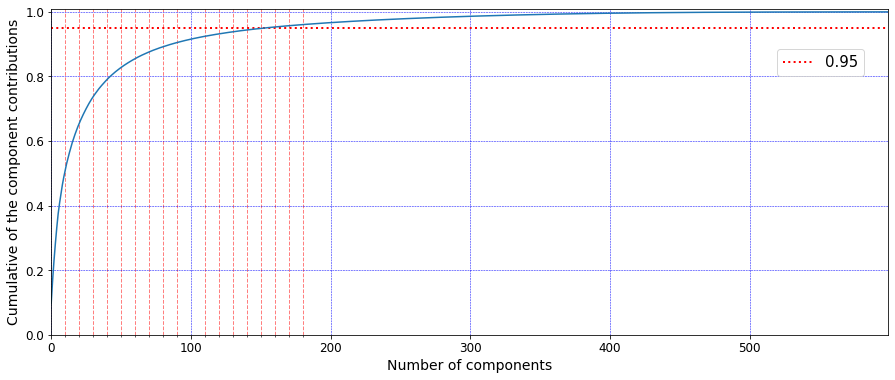

In [43]:
%matplotlib inline
plt.figure(figsize=(15, 6))
plot_coverage(
    ipca.explained_variance_ratio_.cumsum(), 
    "Number of components", 
    "Cumulative of the component contributions"
)

In [44]:
m, n = _X_train.shape
n_batches = 100
n_components=np.argmax(ipca.explained_variance_ratio_.cumsum() >= COVERAGE)
_ipca = IncrementalPCA(
    copy=False,
    n_components=n_components,
    batch_size=(m // n_batches)
)
X_train_recuced_ipca = _ipca.fit_transform(_X_train)
X_train_recovered_ipca = _ipca.inverse_transform(X_train_recuced_ipca)

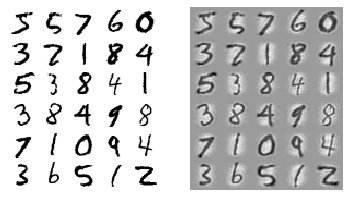

In [45]:
%matplotlib inline
plt.subplot(121)
plot_digits(X_train[::2000])

plt.subplot(122)
plot_digits(X_train_recovered_ipca[::2000])

In [46]:
del X_train_recuced_ipca, X_train_recovered_ipca
del ipca, _ipca

## Numpy memmap
NumPy’s memmap treat a large array stored in a file on disk as if it were entirely in memory. It loads only the data it needs in memory, when it needs it. Since the IncrementalPCA class uses only a small part of the array at any given time, the memory usage remains under control.

In [47]:
np.save("X_train.npy", X_train)
X_mm = np.load('X_train.npy', mmap_mode='r')
X_mm[9179][599]

200.0

In [48]:
from sklearn.decomposition import PCA

m, n = X_train.shape
n_batches = 100

#ipca_mm = IncrementalPCA(batch_size=(m // n_batches))
#ipca_mm.fit(X_mm)
#X_train_recuced_ipca_mm = ipca_mm.fit_transform(X_mm) 

pca_mm = PCA(
    n_components=154,
)
X_train_recuced_pca_mm = pca_mm.fit_transform(X_mm)
X_train_recovered_pca_mm = pca_mm.inverse_transform(X_train_recuced_pca_mm)

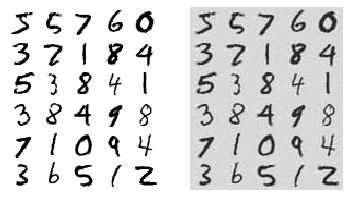

In [49]:
%matplotlib inline
plt.subplot(121)
plot_digits(X_train[::2000])

plt.subplot(122)
plot_digits(X_train_recovered_pca_mm[::2000])

In [50]:
del X_mm, X_train_recovered_pca_mm
del pca_mm